In [65]:
import xml.etree.ElementTree as ET
from pathlib import Path
import csv
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [44]:
counter = dict()
texts = []
sens = []
sens_text = None
clear_texts = []
text = None
clear_text = None
ngramsfd = nltk.FreqDist()

In [45]:
def process_text(text: str, stop_words = set(stopwords.words("english"))):
    global counter, texts, clear_texts, bigramsfd, threegramsfd, sens
    wordnet_lemmatizer = WordNetLemmatizer()    
    sentences = nltk.tokenize.sent_tokenize(text.lower())
    sens.append(nltk.Text(sentences))
    row_words = nltk.tokenize.word_tokenize(text.lower())
    words = [wordnet_lemmatizer.lemmatize(word, tag[0].lower()) if tag[0].lower() in ['a','n','v'] else wordnet_lemmatizer.lemmatize(word) for word, tag in nltk.pos_tag(row_words)]
    texts.append(nltk.Text(words))
    ngrams = nltk.ngrams(row_words, 5)
    ngramsfd.update(ngrams)
    real_words = [word for word in words if word not in stop_words and word[0] not in string.punctuation and word[0] not in string.digits and (len(word) < 2 or word[1] not in string.punctuation)]
    clear_texts.append(nltk.Text(real_words))
    for word in real_words:
        if word not in counter.keys():
            counter[word] = 0
        counter[word] += 1

In [46]:
def process_element(element, stop_words = set(stopwords.words("english"))):
    if element.text is not None:
        process_text(element.text, stop_words)
    for child in element:
        if child.tag == "*/code" or child.tag == "code":
            continue
        process_element(child)

In [47]:
def process_post(post: str, stop_words = set(stopwords.words("english"))) -> int:
    try:
        root = ET.fromstring("<root>"+post+"</root>")
        process_element(root, stop_words)
        return 0
    except ET.ParseError:
        return 1

In [48]:
path = Path('/home/denis/StackOverflow-Frequencies/StackOverflow-Posts.csv')

In [49]:
with open(path) as src:
    global counter, texts, text, clear_texts, clear_text, ngramsfd, sens, sens_text
    counter = dict()
    texts = []
    clear_texts = []
    sens = []
    ngramsfd = nltk.FreqDist()
    reader = csv.DictReader(src, dialect=csv.get_dialect('unix'))
    errors = 0
    for idx, line in enumerate(reader):
        errors += process_post(line['Body'])
    text = nltk.TextCollection(texts)
    clear_text = nltk.TextCollection(clear_texts)
    sens_text = nltk.TextCollection(sens)
    print(errors)

399


In [25]:
count_sum = sum(counter.values())
freq = dict()
for key, val in counter.items():
    freq[key] = val / count_sum

In [29]:
df = pd.DataFrame.from_records(list(counter.items()), columns=["word", "count"])
print(df.sort_values(by="count", ascending=False).head(30).to_markdown(index=False))
display(df.sort_values(by="count", ascending=False).head(30))

| word     |   count |
|:---------|--------:|
| use      |   32543 |
| try      |   15833 |
| code     |   15796 |
| get      |   13683 |
| like     |   12610 |
| work     |   12524 |
| want     |   11158 |
| file     |   10898 |
| need     |    9674 |
| error    |    9650 |
| data     |    8500 |
| create   |    8265 |
| would    |    8137 |
| one      |    7809 |
| value    |    7720 |
| function |    7414 |
| run      |    7368 |
| add      |    7308 |
| way      |    6989 |
| make     |    6753 |
| problem  |    6381 |
| example  |    6368 |
| http     |    6041 |
| change   |    5860 |
| also     |    5812 |
| find     |    5791 |
| call     |    5132 |
| user     |    5042 |
| first    |    5008 |
| look     |    5007 |


,word,count
92,use,32543
76,try,15833
1,code,15796
55,get,13683
83,like,12610
207,work,12524
12,want,11158
11,file,10898
166,need,9674
97,error,9650


In [108]:
data_ngrams = [(" ".join(list(ngr_row)), f) for ngr_row, f in ngramsfd.items() if ngr_row[0][0] not in string.punctuation and ngr_row[0][0] not in string.digits]
df_ngrams = pd.DataFrame.from_records(data_ngrams, columns=["ngram", "count"])
print(df_ngrams.sort_values(by="count", ascending=False).head(15).to_markdown(index=False))
display(df_ngrams.sort_values(by="count", ascending=False).head(20))

| ngram                         |   count |
|:------------------------------|--------:|
| is there a way to             |     638 |
| i do n't know how             |     320 |
| do n't know how to            |     304 |
| is there any way to           |     276 |
| but i do n't know             |     206 |
| what am i doing wrong         |     191 |
| i get the following error     |     191 |
| here is my code :             |     174 |
| i do n't want to              |     169 |
| i am trying to create         |     163 |
| but when i try to             |     149 |
| i want to create a            |     145 |
| want to be able to            |     143 |
| i am trying to use            |     140 |
| any help would be appreciated |     138 |


,ngram,count
1494,is there a way to,638
11064,i do n't know how,320
11065,do n't know how to,304
3230,is there any way to,276
9605,but i do n't know,206
4017,what am i doing wrong,191
206,i get the following error,191
17273,here is my code :,174
2436,i do n't want to,169
4509,i am trying to create,163


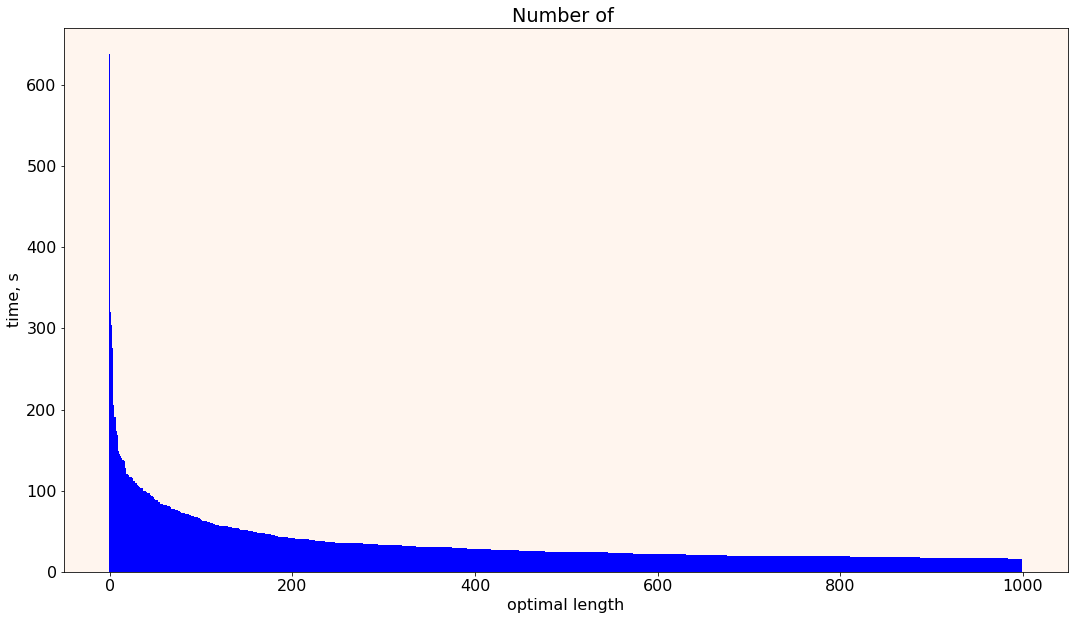

In [109]:
fig, ax = plt.subplots()

for i, count in enumerate(df_ngrams.sort_values(by="count", ascending=False).head(1000)["count"]):
    ax.bar(i, count, width = 1, color='blue')

ax.set_facecolor('seashell')
fig.set_figwidth(18)    #  ширина Figure
fig.set_figheight(10)    #  высота Figure
plt.ylabel("time, s")
plt.xlabel("optimal length")
plt.title("Number of ")
plt.show()

<Figure size 1008x576 with 0 Axes>

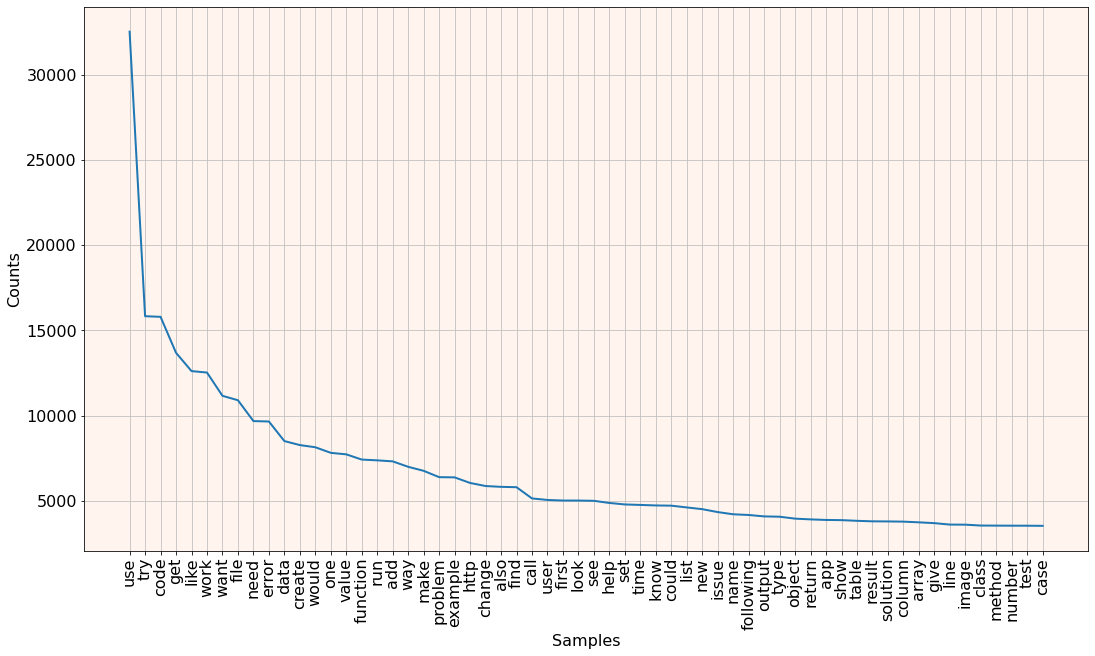

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [51]:
plt.figure(figsize=(14, 8))
plt.rcParams['font.size'] = '16'
fig, ax = plt.subplots()
ax.set_facecolor('seashell')
fig.set_figwidth(18)    #  ширина Figure
fig.set_figheight(10)    #  высота Figure
#plt.title("Number of ")
clear_text.plot(60)

In [107]:
text.collocations(10)

look like; something like; would like; work fine; n't know; visual
studio; make sure; please help; error message; n't work


<Figure size 1008x576 with 0 Axes>

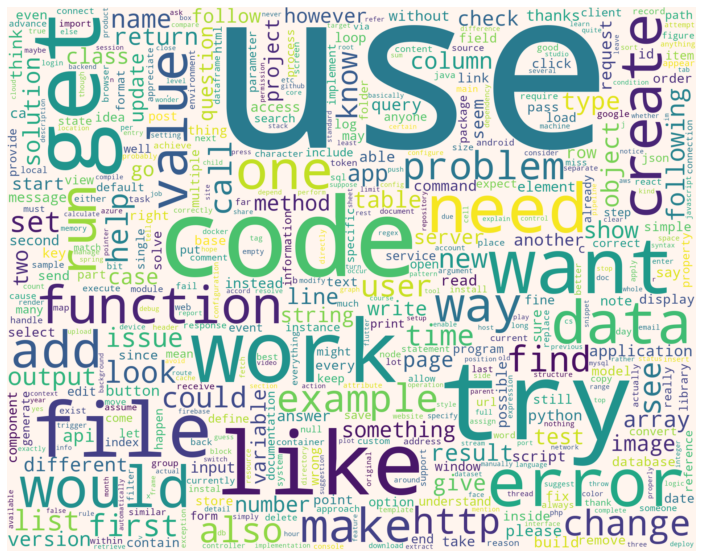

In [69]:
plt.figure(figsize=(14, 8))
plt.rcParams['font.size'] = '16'
fig, ax = plt.subplots()
ax.set_facecolor('seashell')
fig.set_figwidth(18)    #  ширина Figure
fig.set_figheight(10)
wordcloud = WordCloud(width=1900,height=1500, max_words=512,relative_scaling=1,normalize_plurals=False, background_color='seashell').generate_from_frequencies(frequencies=freq)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()